# **Anomaly Detection in Fashion MNIST Using CNN and Autoencoder**

---
This project demonstrates how to detect anomalies in the Fashion MNIST dataset using two approaches:

*   CNN (Convolutional Neural Network) for classification of normal fashion items
*   Autoencoder for detecting anomalous (corrupted) fashion items




## **1. Loading and Preprocessing Fashion MNIST**
First, we mount Google Drive and import necessary libraries. Then, we load the Fashion MNIST dataset, which consists of 60,000 training and 10,000 test grayscale images of 10 fashion categories.

In [1]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [3]:
# Load Fashion MNIST
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Preprocessing Steps:
Reshape images to (28, 28, 1) for CNN input.

Normalize pixel values to [0, 1] by dividing by 255.

In [4]:
# Preprocess
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255

In [5]:
# Class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## **2. CNN for Fashion MNIST Classification**
We build a CNN model to classify fashion items into 10 categories. This helps establish a baseline understanding of normal fashion items before detecting anomalies.

**Model Architecture:**



*   Three Conv2D layers with ReLU activation.

*   MaxPooling for downsampling.
*   Dense layers for final classification.

*   Softmax for multi-class probability output.








In [6]:
# CNN Classification Model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
# Train
history = model.fit(train_images, train_labels, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7018 - loss: 0.8196 - val_accuracy: 0.8579 - val_loss: 0.4063
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8627 - loss: 0.3796 - val_accuracy: 0.8820 - val_loss: 0.3300
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8830 - loss: 0.3162 - val_accuracy: 0.8910 - val_loss: 0.2998
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9017 - loss: 0.2724 - val_accuracy: 0.8962 - val_loss: 0.2808
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9081 - loss: 0.2496 - val_accuracy: 0.9020 - val_loss: 0.2734


In [9]:
# Evaluate
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8973 - loss: 0.2887
Test accuracy: 0.8977000117301941


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


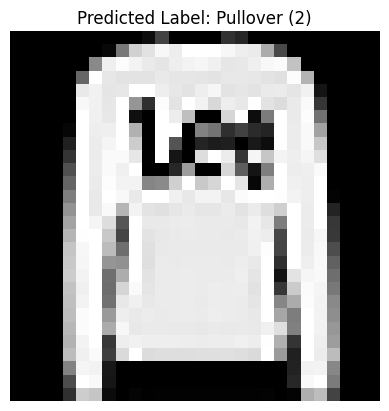

In [10]:
# Predict the output for the first test image
image_index = 1  # Change this index to test other images
test_image = test_images[image_index:image_index+1]  # Add batch dimension

# Predict probabilities
predictions = model.predict(test_image)
predicted_class = np.argmax(predictions)  # Get the class with the highest probability

# Display the image and prediction
plt.imshow(test_images[image_index].reshape(28, 28), cmap='gray')
plt.title(f"Predicted Label: {class_names[predicted_class]} ({predicted_class})")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


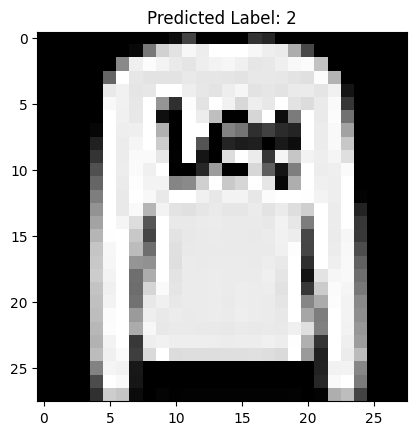

In [11]:
import numpy as np
import matplotlib.pyplot as plt
# Predict the output for the first test image
image_index = 1  # You can change this to test a different image
test_image = test_images[image_index:image_index+1]  # Add batch dimension
# Predict probabilities
predictions = model.predict(test_image)
predicted_class = np.argmax(predictions)  # Get the class with the highest probability
# Display the image and prediction
plt.imshow(test_images[image_index].reshape(28, 28), cmap='gray')
plt.title(f"Predicted Label: {predicted_class}")
plt.show()

## **3. Creating Synthetic Anomalies**
To evaluate anomaly detection, we artificially create anomalies by:

1.   Adding Gaussian noise.
2.   Randomly rotating images.
3.   Combining both noise and rotation.




In [12]:
from scipy.ndimage import rotate, shift
# Function to add Gaussian noise
def add_noise(images, noise_factor=0.5):
    noisy = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy = np.clip(noisy, 0., 1.)  # keep pixels between 0 and 1
    return noisy

# Function to randomly rotate images
def rotate_images(images, max_angle=30):
    rotated = np.zeros_like(images)
    for i in range(images.shape[0]):
        angle = np.random.uniform(-max_angle, max_angle)
        rotated[i, :, :, 0] = rotate(images[i, :, :, 0], angle=angle, reshape=False, mode='nearest')
    return rotated

# Function to apply both noise and rotation
def add_noise_and_rotate(images):
    noisy_images = add_noise(images, noise_factor=0.5)
    noisy_rotated_images = rotate_images(noisy_images)
    return noisy_rotated_images

In [13]:
# ---------- CREATE ANOMALOUS DATA ----------

# Pick a small subset for anomalies (e.g., 2000 samples)
num_anomalies = 2000

# Randomly select images
random_idx = np.random.choice(test_images.shape[0], num_anomalies, replace=False)
normal_samples = test_images[random_idx]

# Create anomalies
anomaly_noise = add_noise(normal_samples)
anomaly_rotated = rotate_images(normal_samples)
anomaly_noise_rotated = add_noise_and_rotate(normal_samples)

# Combine anomalies
anomalous_images = np.concatenate((anomaly_noise, anomaly_rotated, anomaly_noise_rotated), axis=0)
anomalous_labels = np.full(anomalous_images.shape[0], -1)  # Label anomalies with -1

# Now, normal test images have label 0, anomalies have label -1
normal_labels = np.zeros(test_images.shape[0])

# Combine normal + anomalous data
X_full = np.concatenate((test_images, anomalous_images), axis=0)
y_full = np.concatenate((normal_labels, anomalous_labels), axis=0)

print("Anomalies created!")
print(f"Normal samples: {test_images.shape[0]}")
print(f"Anomalous samples: {anomalous_images.shape[0]}")
print(f"Total samples after mixing: {X_full.shape[0]}")

Anomalies created!
Normal samples: 10000
Anomalous samples: 6000
Total samples after mixing: 16000


**Visualizing Anomalous Data Samples**

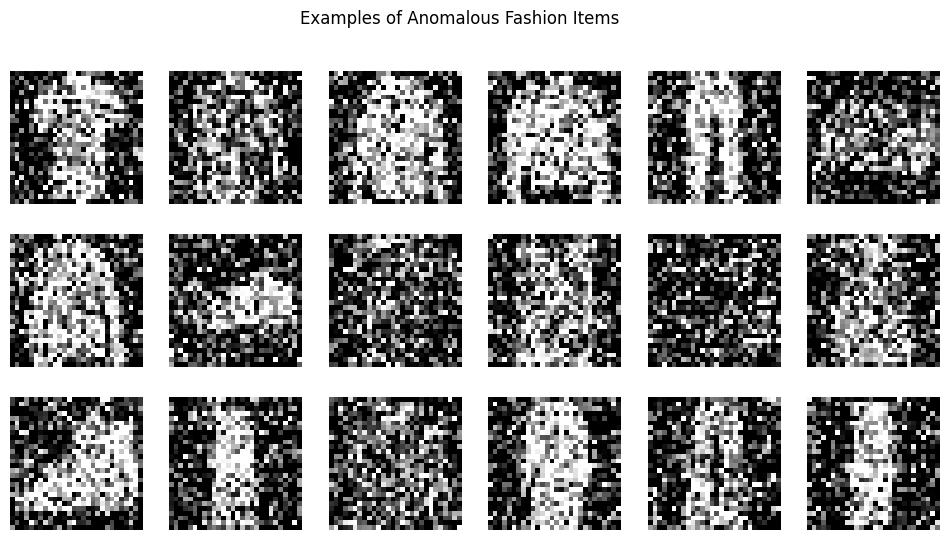

In [14]:
# ---------- VISUALIZE SOME ANOMALIES ----------
fig, axes = plt.subplots(3, 6, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(anomalous_images[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.suptitle('Examples of Anomalous Fashion Items')
plt.show()

## **4. Autoencoder for Anomaly Detection**
An autoencoder is trained to reconstruct normal images. Anomalies will have higher reconstruction errors.

**Autoencoder Structure:**

Encoder: Reduces input to a 64-dimensional latent space.

Decoder: Reconstructs the original image.

Loss: Binary Crossentropy (since pixel values are normalized).



In [15]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Flatten, Reshape

# ---------- BUILD THE AUTOENCODER ----------

# Input layer
input_img = Input(shape=(28,28,1))

# Encoding
x = Flatten()(input_img)
encoded = Dense(128, activation='relu')(x)
encoded = Dense(64, activation='relu')(encoded)

# Decoding
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(28*28, activation='sigmoid')(decoded)
decoded = Reshape((28,28,1))(decoded)

# Autoencoder Model
autoencoder = Model(input_img, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Summary
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 784)            │       101,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 218,192 (852.31 KB)

 Trainable params: 218,192 (852.31 KB)

 Non-trainable params: 0 (0.00 B)

**Training:**

Only normal images are used for training.

The model learns to reconstruct normal fashion items well but struggles with anomalies.

In [16]:
# Remember: Train only on CLEAN (normal) MNIST test set (no anomalies)

# Filter only normal samples (y_full == 0)
normal_idx = np.where(y_full == 0)[0]
X_train_normal = X_full[normal_idx]

# Train the autoencoder
history = autoencoder.fit(X_train_normal, X_train_normal,
                          epochs=20,
                          batch_size=256,
                          shuffle=True,
                          validation_split=0.2)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.6197 - val_loss: 0.4317
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.4071 - val_loss: 0.3723
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3601 - val_loss: 0.3430
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3358 - val_loss: 0.3305
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3270 - val_loss: 0.3257
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3197 - val_loss: 0.3185
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3150 - val_loss: 0.3149
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3114 - val_loss: 0.3115
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3073 - val_loss: 0.3095
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3062 - val_loss: 0.3081
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3032 - val_loss: 0.3058
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3023 - val_l

## **5. Evaluating Anomaly Detection**
We compute reconstruction errors (MSE) and set a threshold to classify anomalies.

In [17]:
# Predict reconstructed images for all samples (normal + anomalies)
reconstructed = autoencoder.predict(X_full)

# Calculate mean squared error for each sample
mse = np.mean(np.power(X_full - reconstructed, 2), axis=(1,2,3))

# Let's see some reconstruction errors
print("Sample reconstruction errors:", mse[:5])

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Sample reconstruction errors: [0.0092086  0.02846874 0.00953245 0.00786839 0.01314546]


We set the threshold at the **95th percentile** of reconstruction errors from normal samples. This means:

Any sample with MSE > threshold is classified as an anomaly.

Samples with MSE ≤ threshold are classified as normal

In [18]:
 # Set threshold using 95th percentile of MSE from normal samples
threshold = np.percentile(mse[normal_idx], 95)
print("Anomaly detection threshold (95th percentile):", threshold)

# Predict: 0 for normal, 1 for anomaly
y_pred = (mse > threshold).astype(int)

# True Labels: 0 (normal) -> 0, -1 (anomaly) -> 1
y_true = (y_full == -1).astype(int)



Anomaly detection threshold (95th percentile): 0.03456939017989444


In [19]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred))

# ROC-AUC Score
roc_score = roc_auc_score(y_true, mse)
print(f"ROC-AUC Score: {roc_score:.4f}")


Confusion Matrix:
 [[9500  500]
 [1117 4883]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92     10000
           1       0.91      0.81      0.86      6000

    accuracy                           0.90     16000
   macro avg       0.90      0.88      0.89     16000
weighted avg       0.90      0.90      0.90     16000

ROC-AUC Score: 0.9443


## **6. Visualization of Results**

**Visualizing Reconstruction Error Distribution**

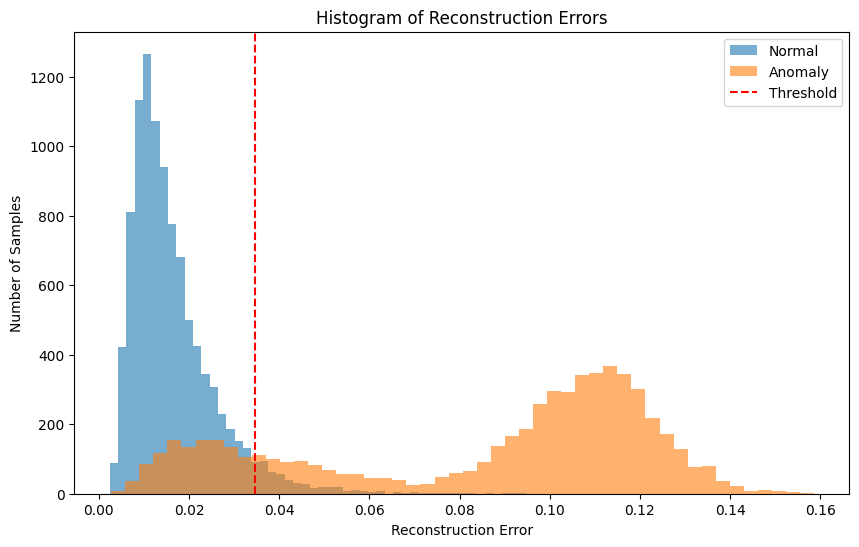

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(mse[y_true==0], bins=50, alpha=0.6, label='Normal')
plt.hist(mse[y_true==1], bins=50, alpha=0.6, label='Anomaly')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.xlabel('Reconstruction Error')
plt.ylabel('Number of Samples')
plt.title('Histogram of Reconstruction Errors')
plt.show()

**Visualizing Training Loss Curve**

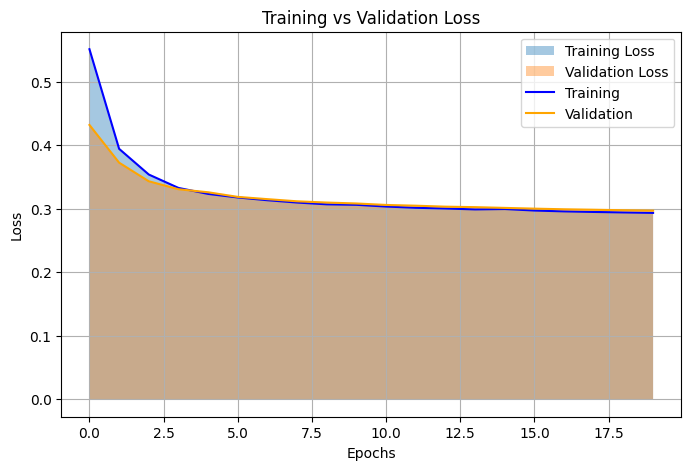

In [21]:
plt.figure(figsize=(8,5))
plt.fill_between(range(len(history.history['loss'])), history.history['loss'], alpha=0.4, label='Training Loss')
plt.fill_between(range(len(history.history['val_loss'])), history.history['val_loss'], alpha=0.4, label='Validation Loss')
plt.plot(history.history['loss'], label='Training', color='blue')
plt.plot(history.history['val_loss'], label='Validation', color='orange')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**Visual Comparison of Original vs Reconstructed Images**

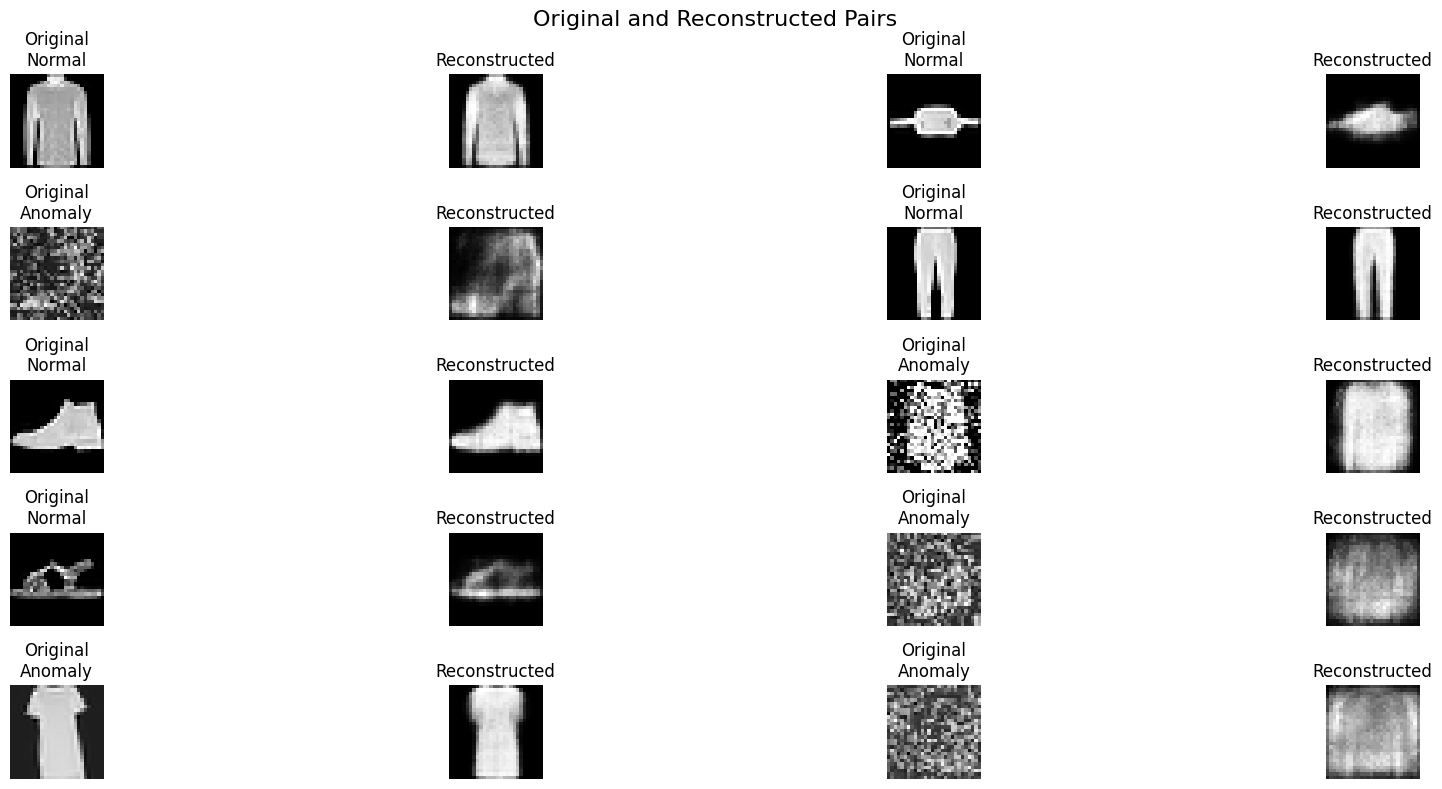

In [24]:
# Select 10 random sample indices (5 pairs of original/reconstructed)
sample_idx = np.random.choice(len(X_full), size=10, replace=False)

plt.figure(figsize=(20, 8))
for i, idx in enumerate(sample_idx):
    ax = plt.subplot(5, 4, 2*i + 1)
    plt.imshow(X_full[idx].reshape(28,28), cmap='gray')
    plt.title(f"Original\n{'Normal' if y_full[idx]==0 else 'Anomaly'}")
    plt.axis('off')

    ax = plt.subplot(5, 4, 2*i + 2)
    plt.imshow(reconstructed[idx].reshape(28,28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.suptitle("Original and Reconstructed Pairs", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()